# Federated Learning Simple Implementation

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import seaborn as sns
from fedlern.utils import *
from fedlern.train_utils import *
from fedlern.quant_utils import *
from fedlern.models.resnet_v2 import ResNet18

## Relevant Parameters

In [46]:
epoch = 10
rounds = 25
num_clients = 10

clients_sample_size = int(.3 * num_clients) # Use 30% of available clients
num_workers = 8
train_batch_size =128
eval_batch_size=256
quantize_bits = 3
stats = (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [47]:
 # Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# split the training data
train_splits = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# Data loaders
train_loaders = [DataLoader(dataset=split, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) for split in train_splits]
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified


## Helper Functions for Federated Training
- `client_update` function train the client model on private client data. This is the local training round that takes place at num_selected clients.
- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

In [48]:

def server_aggregate(global_model : torch.nn.Module, client_models):
    """
    The means of the weights of the client models are aggregated to the global model
    """
    global_dict = global_model.state_dict() # Get a copy of the global model state_dict
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_models[i].state_dict()[key].float() for i in range(len(client_models))],0).mean(0)
    global_model.load_state_dict(global_dict)
    
    # Update the client models using the global model
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [49]:
global_model = ResNet18().to(device)
client_models = [ResNet18()
                     .to(device)
                     #.load_state_dict(global_model.state_dict())
                  for _ in range(num_clients)]



# criterion = nn.CrossEntropyLoss() # computes the cross-entropy loss between the predicted and true labels
# optimizers =[optim.Adam(model.parameters(), lr=0.001) for model in client_models]


In [50]:
# Optimizer & criterion based on gobal model
global_optimizer = get_model_optimizer(global_model,
                                       learning_rate=0.1,
                                       weight_decay=5e-4)

#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,120,160], gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device) # computes the cross-entropy loss between the predicted and true labels

optimizers = [get_model_optimizer(model,learning_rate=0.1, weight_decay=5e-4) for model in client_models]

In [51]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for round in tqdm(range(rounds)):


    # Select n random clients
    selected_clients = np.random.permutation(num_clients)[:clients_sample_size]
    # Train the selected clients
    for client in selected_clients:
        # Individual criterion and optimizer

        train_loss, train_acc = qtrain_model(model = client_models[client],
                                             train_loader = train_loaders[client],
                                             device = device,
                                             criterion = criterion,
                                             optimizer = optimizers[client],
                                             num_epochs=epoch,
                                             bits = quantize_bits)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Aggregate
    server_aggregate(global_model, client_models)

    # Test the global model
    test_loss, test_acc = evaluate_model(model=global_model,
                                         test_loader=test_loader,
                                         device=device,
                                         criterion=criterion)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{round}-th ROUND: average train loss {(train_loss / clients_sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0/10 Train Loss: 3.037 Train Acc: 0.171
Epoch: 1/10 Train Loss: 2.373 Train Acc: 0.199
Epoch: 2/10 Train Loss: 2.066 Train Acc: 0.214
Epoch: 3/10 Train Loss: 2.019 Train Acc: 0.236
Epoch: 4/10 Train Loss: 2.025 Train Acc: 0.238
Epoch: 5/10 Train Loss: 2.015 Train Acc: 0.236
Epoch: 6/10 Train Loss: 2.017 Train Acc: 0.243
Epoch: 7/10 Train Loss: 2.020 Train Acc: 0.236
Epoch: 8/10 Train Loss: 2.013 Train Acc: 0.236
Epoch: 9/10 Train Loss: 2.014 Train Acc: 0.234
Epoch: 0/10 Train Loss: 2.954 Train Acc: 0.162
Epoch: 1/10 Train Loss: 2.282 Train Acc: 0.173
Epoch: 2/10 Train Loss: 2.081 Train Acc: 0.223
Epoch: 3/10 Train Loss: 2.033 Train Acc: 0.247
Epoch: 4/10 Train Loss: 2.036 Train Acc: 0.248
Epoch: 5/10 Train Loss: 2.032 Train Acc: 0.250
Epoch: 6/10 Train Loss: 2.030 Train Acc: 0.252
Epoch: 7/10 Train Loss: 2.031 Train Acc: 0.244
Epoch: 8/10 Train Loss: 2.032 Train Acc: 0.245
Epoch: 9/10 Train Loss: 2.030 Train Acc: 0.252
Epoch: 0/10 Train Loss: 3.253 Train Acc: 0.151
Epoch: 1/10 T

  3%|▎         | 1/30 [05:15<2:32:20, 315.20s/it]

0-th ROUND: average train loss 0.675 | test loss 2.3 | test acc: 0.100
Epoch: 0/10 Train Loss: 2.137 Train Acc: 0.198
Epoch: 1/10 Train Loss: 2.094 Train Acc: 0.212
Epoch: 2/10 Train Loss: 1.979 Train Acc: 0.237
Epoch: 3/10 Train Loss: 1.918 Train Acc: 0.268
Epoch: 4/10 Train Loss: 1.908 Train Acc: 0.268
Epoch: 5/10 Train Loss: 1.910 Train Acc: 0.269
Epoch: 6/10 Train Loss: 1.900 Train Acc: 0.273
Epoch: 7/10 Train Loss: 1.900 Train Acc: 0.272
Epoch: 8/10 Train Loss: 1.902 Train Acc: 0.272
Epoch: 9/10 Train Loss: 1.898 Train Acc: 0.280
Epoch: 0/10 Train Loss: 2.343 Train Acc: 0.097
Epoch: 1/10 Train Loss: 2.271 Train Acc: 0.125
Epoch: 2/10 Train Loss: 2.231 Train Acc: 0.156
Epoch: 3/10 Train Loss: 2.227 Train Acc: 0.160
Epoch: 4/10 Train Loss: 2.226 Train Acc: 0.156
Epoch: 5/10 Train Loss: 2.224 Train Acc: 0.158
Epoch: 6/10 Train Loss: 2.228 Train Acc: 0.157
Epoch: 7/10 Train Loss: 2.228 Train Acc: 0.159
Epoch: 8/10 Train Loss: 2.226 Train Acc: 0.158
Epoch: 9/10 Train Loss: 2.224 Train 

  7%|▋         | 2/30 [10:30<2:27:04, 315.16s/it]

1-th ROUND: average train loss 0.745 | test loss 2.31 | test acc: 0.100
Epoch: 0/10 Train Loss: 2.123 Train Acc: 0.212
Epoch: 1/10 Train Loss: 2.069 Train Acc: 0.239
Epoch: 2/10 Train Loss: 2.051 Train Acc: 0.233
Epoch: 3/10 Train Loss: 2.045 Train Acc: 0.242
Epoch: 4/10 Train Loss: 2.047 Train Acc: 0.239
Epoch: 5/10 Train Loss: 2.047 Train Acc: 0.233
Epoch: 6/10 Train Loss: 2.045 Train Acc: 0.236
Epoch: 7/10 Train Loss: 2.046 Train Acc: 0.240
Epoch: 8/10 Train Loss: 2.045 Train Acc: 0.238
Epoch: 9/10 Train Loss: 2.046 Train Acc: 0.245
Epoch: 0/10 Train Loss: 2.125 Train Acc: 0.198
Epoch: 1/10 Train Loss: 2.074 Train Acc: 0.229
Epoch: 2/10 Train Loss: 2.052 Train Acc: 0.239
Epoch: 3/10 Train Loss: 2.051 Train Acc: 0.232
Epoch: 4/10 Train Loss: 2.051 Train Acc: 0.238
Epoch: 5/10 Train Loss: 2.053 Train Acc: 0.232
Epoch: 6/10 Train Loss: 2.051 Train Acc: 0.231
Epoch: 7/10 Train Loss: 2.054 Train Acc: 0.229
Epoch: 8/10 Train Loss: 2.050 Train Acc: 0.233
Epoch: 9/10 Train Loss: 2.049 Train

 10%|█         | 3/30 [15:45<2:21:48, 315.14s/it]

2-th ROUND: average train loss 0.622 | test loss 2.31 | test acc: 0.100
Epoch: 0/10 Train Loss: 2.045 Train Acc: 0.224
Epoch: 1/10 Train Loss: 2.120 Train Acc: 0.221
Epoch: 2/10 Train Loss: 1.934 Train Acc: 0.260
Epoch: 3/10 Train Loss: 1.884 Train Acc: 0.304
Epoch: 4/10 Train Loss: 1.884 Train Acc: 0.293
Epoch: 5/10 Train Loss: 1.878 Train Acc: 0.302
Epoch: 6/10 Train Loss: 1.875 Train Acc: 0.300
Epoch: 7/10 Train Loss: 1.870 Train Acc: 0.308
Epoch: 8/10 Train Loss: 1.874 Train Acc: 0.305
Epoch: 9/10 Train Loss: 1.878 Train Acc: 0.294
Epoch: 0/10 Train Loss: 2.057 Train Acc: 0.232
Epoch: 1/10 Train Loss: 2.059 Train Acc: 0.229
Epoch: 2/10 Train Loss: 2.057 Train Acc: 0.232
Epoch: 3/10 Train Loss: 2.055 Train Acc: 0.224
Epoch: 4/10 Train Loss: 2.057 Train Acc: 0.230
Epoch: 5/10 Train Loss: 2.056 Train Acc: 0.230
Epoch: 6/10 Train Loss: 2.056 Train Acc: 0.230
Epoch: 7/10 Train Loss: 2.058 Train Acc: 0.226
Epoch: 8/10 Train Loss: 2.057 Train Acc: 0.229
Epoch: 9/10 Train Loss: 2.057 Train

 13%|█▎        | 4/30 [21:00<2:16:31, 315.04s/it]

3-th ROUND: average train loss 0.579 | test loss 2.32 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.990 Train Acc: 0.240
Epoch: 1/10 Train Loss: 1.990 Train Acc: 0.247
Epoch: 2/10 Train Loss: 1.990 Train Acc: 0.242
Epoch: 3/10 Train Loss: 1.990 Train Acc: 0.237
Epoch: 4/10 Train Loss: 1.986 Train Acc: 0.239
Epoch: 5/10 Train Loss: 1.993 Train Acc: 0.238
Epoch: 6/10 Train Loss: 1.990 Train Acc: 0.239
Epoch: 7/10 Train Loss: 1.989 Train Acc: 0.247
Epoch: 8/10 Train Loss: 1.991 Train Acc: 0.235
Epoch: 9/10 Train Loss: 1.988 Train Acc: 0.243
Epoch: 0/10 Train Loss: 1.993 Train Acc: 0.239
Epoch: 1/10 Train Loss: 1.989 Train Acc: 0.246
Epoch: 2/10 Train Loss: 1.986 Train Acc: 0.245
Epoch: 3/10 Train Loss: 1.990 Train Acc: 0.243
Epoch: 4/10 Train Loss: 1.995 Train Acc: 0.242
Epoch: 5/10 Train Loss: 1.992 Train Acc: 0.244
Epoch: 6/10 Train Loss: 1.990 Train Acc: 0.246
Epoch: 7/10 Train Loss: 1.992 Train Acc: 0.253
Epoch: 8/10 Train Loss: 1.992 Train Acc: 0.244
Epoch: 9/10 Train Loss: 1.994 Train

 17%|█▋        | 5/30 [26:15<2:11:17, 315.08s/it]

4-th ROUND: average train loss 0.654 | test loss 2.32 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.972 Train Acc: 0.259
Epoch: 1/10 Train Loss: 1.960 Train Acc: 0.261
Epoch: 2/10 Train Loss: 1.947 Train Acc: 0.269
Epoch: 3/10 Train Loss: 1.947 Train Acc: 0.275
Epoch: 4/10 Train Loss: 1.950 Train Acc: 0.267
Epoch: 5/10 Train Loss: 1.952 Train Acc: 0.261
Epoch: 6/10 Train Loss: 1.948 Train Acc: 0.264
Epoch: 7/10 Train Loss: 1.947 Train Acc: 0.269
Epoch: 8/10 Train Loss: 1.947 Train Acc: 0.270
Epoch: 9/10 Train Loss: 1.951 Train Acc: 0.274
Epoch: 0/10 Train Loss: 1.975 Train Acc: 0.252
Epoch: 1/10 Train Loss: 1.971 Train Acc: 0.254
Epoch: 2/10 Train Loss: 1.973 Train Acc: 0.255
Epoch: 3/10 Train Loss: 1.975 Train Acc: 0.252
Epoch: 4/10 Train Loss: 1.975 Train Acc: 0.255
Epoch: 5/10 Train Loss: 1.974 Train Acc: 0.250
Epoch: 6/10 Train Loss: 1.975 Train Acc: 0.266
Epoch: 7/10 Train Loss: 1.975 Train Acc: 0.248
Epoch: 8/10 Train Loss: 1.976 Train Acc: 0.256
Epoch: 9/10 Train Loss: 1.973 Train

 20%|██        | 6/30 [31:30<2:06:04, 315.18s/it]

5-th ROUND: average train loss 0.65 | test loss 2.33 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.983 Train Acc: 0.247
Epoch: 1/10 Train Loss: 1.984 Train Acc: 0.245
Epoch: 2/10 Train Loss: 1.985 Train Acc: 0.246
Epoch: 3/10 Train Loss: 1.981 Train Acc: 0.240
Epoch: 4/10 Train Loss: 1.983 Train Acc: 0.252
Epoch: 5/10 Train Loss: 1.983 Train Acc: 0.240
Epoch: 6/10 Train Loss: 1.983 Train Acc: 0.245
Epoch: 7/10 Train Loss: 1.984 Train Acc: 0.245
Epoch: 8/10 Train Loss: 1.983 Train Acc: 0.250
Epoch: 9/10 Train Loss: 1.982 Train Acc: 0.241
Epoch: 0/10 Train Loss: 1.985 Train Acc: 0.246
Epoch: 1/10 Train Loss: 1.987 Train Acc: 0.248
Epoch: 2/10 Train Loss: 1.983 Train Acc: 0.251
Epoch: 3/10 Train Loss: 1.985 Train Acc: 0.246
Epoch: 4/10 Train Loss: 1.982 Train Acc: 0.246
Epoch: 5/10 Train Loss: 1.985 Train Acc: 0.246
Epoch: 6/10 Train Loss: 1.985 Train Acc: 0.251
Epoch: 7/10 Train Loss: 1.986 Train Acc: 0.249
Epoch: 8/10 Train Loss: 1.982 Train Acc: 0.251
Epoch: 9/10 Train Loss: 1.985 Train 

 23%|██▎       | 7/30 [36:45<2:00:43, 314.95s/it]

6-th ROUND: average train loss 0.605 | test loss 2.34 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.930 Train Acc: 0.276
Epoch: 1/10 Train Loss: 1.926 Train Acc: 0.273
Epoch: 2/10 Train Loss: 1.930 Train Acc: 0.265
Epoch: 3/10 Train Loss: 1.928 Train Acc: 0.273
Epoch: 4/10 Train Loss: 1.923 Train Acc: 0.273
Epoch: 5/10 Train Loss: 1.929 Train Acc: 0.283
Epoch: 6/10 Train Loss: 1.926 Train Acc: 0.267
Epoch: 7/10 Train Loss: 1.922 Train Acc: 0.269
Epoch: 8/10 Train Loss: 1.928 Train Acc: 0.268
Epoch: 9/10 Train Loss: 1.924 Train Acc: 0.272
Epoch: 0/10 Train Loss: 1.937 Train Acc: 0.261
Epoch: 1/10 Train Loss: 1.939 Train Acc: 0.262
Epoch: 2/10 Train Loss: 1.936 Train Acc: 0.259
Epoch: 3/10 Train Loss: 1.938 Train Acc: 0.261
Epoch: 4/10 Train Loss: 1.939 Train Acc: 0.255
Epoch: 5/10 Train Loss: 1.938 Train Acc: 0.262
Epoch: 6/10 Train Loss: 1.939 Train Acc: 0.257
Epoch: 7/10 Train Loss: 1.937 Train Acc: 0.261
Epoch: 8/10 Train Loss: 1.939 Train Acc: 0.263
Epoch: 9/10 Train Loss: 1.940 Train

 27%|██▋       | 8/30 [42:00<1:55:30, 315.02s/it]

7-th ROUND: average train loss 0.577 | test loss 2.34 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.889 Train Acc: 0.287
Epoch: 1/10 Train Loss: 1.890 Train Acc: 0.287
Epoch: 2/10 Train Loss: 1.893 Train Acc: 0.283
Epoch: 3/10 Train Loss: 1.892 Train Acc: 0.287
Epoch: 4/10 Train Loss: 1.882 Train Acc: 0.286
Epoch: 5/10 Train Loss: 1.887 Train Acc: 0.291
Epoch: 6/10 Train Loss: 1.887 Train Acc: 0.288
Epoch: 7/10 Train Loss: 1.886 Train Acc: 0.286
Epoch: 8/10 Train Loss: 1.895 Train Acc: 0.282
Epoch: 9/10 Train Loss: 1.888 Train Acc: 0.286
Epoch: 0/10 Train Loss: 1.899 Train Acc: 0.278
Epoch: 1/10 Train Loss: 1.901 Train Acc: 0.275
Epoch: 2/10 Train Loss: 1.897 Train Acc: 0.278
Epoch: 3/10 Train Loss: 1.903 Train Acc: 0.278
Epoch: 4/10 Train Loss: 1.894 Train Acc: 0.279
Epoch: 5/10 Train Loss: 1.905 Train Acc: 0.272
Epoch: 6/10 Train Loss: 1.899 Train Acc: 0.277
Epoch: 7/10 Train Loss: 1.901 Train Acc: 0.279
Epoch: 8/10 Train Loss: 1.898 Train Acc: 0.283
Epoch: 9/10 Train Loss: 1.902 Train

 30%|███       | 9/30 [47:15<1:50:16, 315.08s/it]

8-th ROUND: average train loss 0.577 | test loss 2.34 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.885 Train Acc: 0.295
Epoch: 1/10 Train Loss: 1.882 Train Acc: 0.289
Epoch: 2/10 Train Loss: 1.876 Train Acc: 0.286
Epoch: 3/10 Train Loss: 1.883 Train Acc: 0.288
Epoch: 4/10 Train Loss: 1.878 Train Acc: 0.287
Epoch: 5/10 Train Loss: 1.876 Train Acc: 0.286
Epoch: 6/10 Train Loss: 1.875 Train Acc: 0.290
Epoch: 7/10 Train Loss: 1.885 Train Acc: 0.290
Epoch: 8/10 Train Loss: 1.877 Train Acc: 0.291
Epoch: 9/10 Train Loss: 1.884 Train Acc: 0.289
Epoch: 0/10 Train Loss: 1.871 Train Acc: 0.287
Epoch: 1/10 Train Loss: 1.852 Train Acc: 0.300
Epoch: 2/10 Train Loss: 1.848 Train Acc: 0.300
Epoch: 3/10 Train Loss: 1.846 Train Acc: 0.303
Epoch: 4/10 Train Loss: 1.845 Train Acc: 0.313
Epoch: 5/10 Train Loss: 1.848 Train Acc: 0.299
Epoch: 6/10 Train Loss: 1.850 Train Acc: 0.302
Epoch: 7/10 Train Loss: 1.843 Train Acc: 0.302
Epoch: 8/10 Train Loss: 1.850 Train Acc: 0.301
Epoch: 9/10 Train Loss: 1.841 Train

 33%|███▎      | 10/30 [52:31<1:45:04, 315.20s/it]

9-th ROUND: average train loss 0.619 | test loss 2.33 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.868 Train Acc: 0.291
Epoch: 1/10 Train Loss: 1.874 Train Acc: 0.289
Epoch: 2/10 Train Loss: 1.868 Train Acc: 0.297
Epoch: 3/10 Train Loss: 1.874 Train Acc: 0.290
Epoch: 4/10 Train Loss: 1.876 Train Acc: 0.292
Epoch: 5/10 Train Loss: 1.878 Train Acc: 0.292
Epoch: 6/10 Train Loss: 1.870 Train Acc: 0.296
Epoch: 7/10 Train Loss: 1.872 Train Acc: 0.290
Epoch: 8/10 Train Loss: 1.870 Train Acc: 0.298
Epoch: 9/10 Train Loss: 1.874 Train Acc: 0.287
Epoch: 0/10 Train Loss: 1.861 Train Acc: 0.291
Epoch: 1/10 Train Loss: 1.845 Train Acc: 0.310
Epoch: 2/10 Train Loss: 1.841 Train Acc: 0.312
Epoch: 3/10 Train Loss: 1.837 Train Acc: 0.305
Epoch: 4/10 Train Loss: 1.832 Train Acc: 0.312
Epoch: 5/10 Train Loss: 1.831 Train Acc: 0.318
Epoch: 6/10 Train Loss: 1.833 Train Acc: 0.314
Epoch: 7/10 Train Loss: 1.831 Train Acc: 0.315
Epoch: 8/10 Train Loss: 1.837 Train Acc: 0.314
Epoch: 9/10 Train Loss: 1.837 Train

 37%|███▋      | 11/30 [57:46<1:39:50, 315.29s/it]

10-th ROUND: average train loss 0.62 | test loss 2.3 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.862 Train Acc: 0.297
Epoch: 1/10 Train Loss: 1.862 Train Acc: 0.293
Epoch: 2/10 Train Loss: 1.868 Train Acc: 0.285
Epoch: 3/10 Train Loss: 1.865 Train Acc: 0.296
Epoch: 4/10 Train Loss: 1.864 Train Acc: 0.291
Epoch: 5/10 Train Loss: 1.865 Train Acc: 0.292
Epoch: 6/10 Train Loss: 1.866 Train Acc: 0.294
Epoch: 7/10 Train Loss: 1.857 Train Acc: 0.304
Epoch: 8/10 Train Loss: 1.867 Train Acc: 0.293
Epoch: 9/10 Train Loss: 1.864 Train Acc: 0.291
Epoch: 0/10 Train Loss: 1.872 Train Acc: 0.295
Epoch: 1/10 Train Loss: 1.879 Train Acc: 0.302
Epoch: 2/10 Train Loss: 1.877 Train Acc: 0.294
Epoch: 3/10 Train Loss: 1.882 Train Acc: 0.289
Epoch: 4/10 Train Loss: 1.883 Train Acc: 0.294
Epoch: 5/10 Train Loss: 1.877 Train Acc: 0.294
Epoch: 6/10 Train Loss: 1.877 Train Acc: 0.293
Epoch: 7/10 Train Loss: 1.875 Train Acc: 0.293
Epoch: 8/10 Train Loss: 1.874 Train Acc: 0.290
Epoch: 9/10 Train Loss: 1.872 Train 

 40%|████      | 12/30 [1:03:02<1:34:36, 315.38s/it]

11-th ROUND: average train loss 0.619 | test loss 2.24 | test acc: 0.111
Epoch: 0/10 Train Loss: 1.860 Train Acc: 0.292
Epoch: 1/10 Train Loss: 1.860 Train Acc: 0.290
Epoch: 2/10 Train Loss: 1.860 Train Acc: 0.292
Epoch: 3/10 Train Loss: 1.859 Train Acc: 0.290
Epoch: 4/10 Train Loss: 1.862 Train Acc: 0.292
Epoch: 5/10 Train Loss: 1.861 Train Acc: 0.294
Epoch: 6/10 Train Loss: 1.861 Train Acc: 0.294
Epoch: 7/10 Train Loss: 1.861 Train Acc: 0.293
Epoch: 8/10 Train Loss: 1.862 Train Acc: 0.289
Epoch: 9/10 Train Loss: 1.864 Train Acc: 0.290
Epoch: 0/10 Train Loss: 1.860 Train Acc: 0.302
Epoch: 1/10 Train Loss: 1.859 Train Acc: 0.298
Epoch: 2/10 Train Loss: 1.859 Train Acc: 0.305
Epoch: 3/10 Train Loss: 1.857 Train Acc: 0.303
Epoch: 4/10 Train Loss: 1.854 Train Acc: 0.309
Epoch: 5/10 Train Loss: 1.858 Train Acc: 0.296
Epoch: 6/10 Train Loss: 1.855 Train Acc: 0.299
Epoch: 7/10 Train Loss: 1.861 Train Acc: 0.299
Epoch: 8/10 Train Loss: 1.856 Train Acc: 0.308
Epoch: 9/10 Train Loss: 1.851 Trai

 43%|████▎     | 13/30 [1:08:17<1:29:18, 315.23s/it]

12-th ROUND: average train loss 0.619 | test loss 2.16 | test acc: 0.166
Epoch: 0/10 Train Loss: 1.860 Train Acc: 0.289
Epoch: 1/10 Train Loss: 1.861 Train Acc: 0.295
Epoch: 2/10 Train Loss: 1.858 Train Acc: 0.296
Epoch: 3/10 Train Loss: 1.859 Train Acc: 0.290
Epoch: 4/10 Train Loss: 1.864 Train Acc: 0.294
Epoch: 5/10 Train Loss: 1.858 Train Acc: 0.295
Epoch: 6/10 Train Loss: 1.865 Train Acc: 0.289
Epoch: 7/10 Train Loss: 1.860 Train Acc: 0.299
Epoch: 8/10 Train Loss: 1.857 Train Acc: 0.298
Epoch: 9/10 Train Loss: 1.863 Train Acc: 0.289
Epoch: 0/10 Train Loss: 1.876 Train Acc: 0.293
Epoch: 1/10 Train Loss: 1.869 Train Acc: 0.296
Epoch: 2/10 Train Loss: 1.870 Train Acc: 0.297
Epoch: 3/10 Train Loss: 1.865 Train Acc: 0.293
Epoch: 4/10 Train Loss: 1.867 Train Acc: 0.297
Epoch: 5/10 Train Loss: 1.874 Train Acc: 0.287
Epoch: 6/10 Train Loss: 1.867 Train Acc: 0.298
Epoch: 7/10 Train Loss: 1.877 Train Acc: 0.282
Epoch: 8/10 Train Loss: 1.869 Train Acc: 0.297
Epoch: 9/10 Train Loss: 1.874 Trai

 47%|████▋     | 14/30 [1:13:32<1:24:04, 315.27s/it]

13-th ROUND: average train loss 0.62 | test loss 2.07 | test acc: 0.216
Epoch: 0/10 Train Loss: 1.847 Train Acc: 0.301
Epoch: 1/10 Train Loss: 1.837 Train Acc: 0.308
Epoch: 2/10 Train Loss: 1.834 Train Acc: 0.306
Epoch: 3/10 Train Loss: 1.831 Train Acc: 0.305
Epoch: 4/10 Train Loss: 1.829 Train Acc: 0.314
Epoch: 5/10 Train Loss: 1.829 Train Acc: 0.308
Epoch: 6/10 Train Loss: 1.834 Train Acc: 0.305
Epoch: 7/10 Train Loss: 1.831 Train Acc: 0.313
Epoch: 8/10 Train Loss: 1.832 Train Acc: 0.308
Epoch: 9/10 Train Loss: 1.829 Train Acc: 0.309
Epoch: 0/10 Train Loss: 1.864 Train Acc: 0.298
Epoch: 1/10 Train Loss: 1.873 Train Acc: 0.291
Epoch: 2/10 Train Loss: 1.873 Train Acc: 0.290
Epoch: 3/10 Train Loss: 1.865 Train Acc: 0.297
Epoch: 4/10 Train Loss: 1.867 Train Acc: 0.297
Epoch: 5/10 Train Loss: 1.865 Train Acc: 0.290
Epoch: 6/10 Train Loss: 1.871 Train Acc: 0.302
Epoch: 7/10 Train Loss: 1.867 Train Acc: 0.299
Epoch: 8/10 Train Loss: 1.878 Train Acc: 0.293
Epoch: 9/10 Train Loss: 1.869 Train

 50%|█████     | 15/30 [1:18:47<1:18:49, 315.29s/it]

14-th ROUND: average train loss 0.62 | test loss 1.99 | test acc: 0.261
Epoch: 0/10 Train Loss: 1.859 Train Acc: 0.289
Epoch: 1/10 Train Loss: 1.861 Train Acc: 0.290
Epoch: 2/10 Train Loss: 1.860 Train Acc: 0.292
Epoch: 3/10 Train Loss: 1.854 Train Acc: 0.296
Epoch: 4/10 Train Loss: 1.863 Train Acc: 0.298
Epoch: 5/10 Train Loss: 1.855 Train Acc: 0.290
Epoch: 6/10 Train Loss: 1.856 Train Acc: 0.290
Epoch: 7/10 Train Loss: 1.856 Train Acc: 0.295
Epoch: 8/10 Train Loss: 1.859 Train Acc: 0.290
Epoch: 9/10 Train Loss: 1.858 Train Acc: 0.291
Epoch: 0/10 Train Loss: 1.852 Train Acc: 0.300
Epoch: 1/10 Train Loss: 1.855 Train Acc: 0.301
Epoch: 2/10 Train Loss: 1.853 Train Acc: 0.296
Epoch: 3/10 Train Loss: 1.852 Train Acc: 0.298
Epoch: 4/10 Train Loss: 1.849 Train Acc: 0.306
Epoch: 5/10 Train Loss: 1.857 Train Acc: 0.304
Epoch: 6/10 Train Loss: 1.855 Train Acc: 0.300
Epoch: 7/10 Train Loss: 1.852 Train Acc: 0.301
Epoch: 8/10 Train Loss: 1.847 Train Acc: 0.305
Epoch: 9/10 Train Loss: 1.852 Train

 53%|█████▎    | 16/30 [1:24:02<1:13:33, 315.21s/it]

15-th ROUND: average train loss 0.624 | test loss 1.93 | test acc: 0.288
Epoch: 0/10 Train Loss: 1.851 Train Acc: 0.302
Epoch: 1/10 Train Loss: 1.861 Train Acc: 0.301
Epoch: 2/10 Train Loss: 1.848 Train Acc: 0.305
Epoch: 3/10 Train Loss: 1.845 Train Acc: 0.298
Epoch: 4/10 Train Loss: 1.855 Train Acc: 0.302
Epoch: 5/10 Train Loss: 1.853 Train Acc: 0.304
Epoch: 6/10 Train Loss: 1.852 Train Acc: 0.304
Epoch: 7/10 Train Loss: 1.848 Train Acc: 0.304
Epoch: 8/10 Train Loss: 1.852 Train Acc: 0.306
Epoch: 9/10 Train Loss: 1.853 Train Acc: 0.301
Epoch: 0/10 Train Loss: 1.854 Train Acc: 0.301
Epoch: 1/10 Train Loss: 1.853 Train Acc: 0.305
Epoch: 2/10 Train Loss: 1.860 Train Acc: 0.296
Epoch: 3/10 Train Loss: 1.859 Train Acc: 0.301
Epoch: 4/10 Train Loss: 1.860 Train Acc: 0.291
Epoch: 5/10 Train Loss: 1.853 Train Acc: 0.296
Epoch: 6/10 Train Loss: 1.861 Train Acc: 0.297
Epoch: 7/10 Train Loss: 1.855 Train Acc: 0.295
Epoch: 8/10 Train Loss: 1.855 Train Acc: 0.303
Epoch: 9/10 Train Loss: 1.855 Trai

 57%|█████▋    | 17/30 [1:29:18<1:08:17, 315.20s/it]

16-th ROUND: average train loss 0.62 | test loss 1.89 | test acc: 0.306
Epoch: 0/10 Train Loss: 1.864 Train Acc: 0.297
Epoch: 1/10 Train Loss: 1.861 Train Acc: 0.289
Epoch: 2/10 Train Loss: 1.861 Train Acc: 0.298
Epoch: 3/10 Train Loss: 1.857 Train Acc: 0.299
Epoch: 4/10 Train Loss: 1.858 Train Acc: 0.294
Epoch: 5/10 Train Loss: 1.866 Train Acc: 0.296
Epoch: 6/10 Train Loss: 1.857 Train Acc: 0.291
Epoch: 7/10 Train Loss: 1.859 Train Acc: 0.298
Epoch: 8/10 Train Loss: 1.861 Train Acc: 0.292
Epoch: 9/10 Train Loss: 1.866 Train Acc: 0.292
Epoch: 0/10 Train Loss: 1.858 Train Acc: 0.290
Epoch: 1/10 Train Loss: 1.862 Train Acc: 0.292
Epoch: 2/10 Train Loss: 1.858 Train Acc: 0.298
Epoch: 3/10 Train Loss: 1.867 Train Acc: 0.289
Epoch: 4/10 Train Loss: 1.859 Train Acc: 0.290
Epoch: 5/10 Train Loss: 1.861 Train Acc: 0.291
Epoch: 6/10 Train Loss: 1.856 Train Acc: 0.289
Epoch: 7/10 Train Loss: 1.856 Train Acc: 0.298
Epoch: 8/10 Train Loss: 1.858 Train Acc: 0.293
Epoch: 9/10 Train Loss: 1.854 Train

 60%|██████    | 18/30 [1:34:33<1:03:03, 315.29s/it]

17-th ROUND: average train loss 0.623 | test loss 1.86 | test acc: 0.308
Epoch: 0/10 Train Loss: 1.863 Train Acc: 0.296
Epoch: 1/10 Train Loss: 1.863 Train Acc: 0.289
Epoch: 2/10 Train Loss: 1.860 Train Acc: 0.295
Epoch: 3/10 Train Loss: 1.863 Train Acc: 0.291
Epoch: 4/10 Train Loss: 1.863 Train Acc: 0.302
Epoch: 5/10 Train Loss: 1.862 Train Acc: 0.294
Epoch: 6/10 Train Loss: 1.856 Train Acc: 0.300
Epoch: 7/10 Train Loss: 1.860 Train Acc: 0.297
Epoch: 8/10 Train Loss: 1.860 Train Acc: 0.295
Epoch: 9/10 Train Loss: 1.862 Train Acc: 0.295
Epoch: 0/10 Train Loss: 1.860 Train Acc: 0.301
Epoch: 1/10 Train Loss: 1.854 Train Acc: 0.299
Epoch: 2/10 Train Loss: 1.859 Train Acc: 0.296
Epoch: 3/10 Train Loss: 1.859 Train Acc: 0.298
Epoch: 4/10 Train Loss: 1.846 Train Acc: 0.309
Epoch: 5/10 Train Loss: 1.854 Train Acc: 0.299
Epoch: 6/10 Train Loss: 1.854 Train Acc: 0.302
Epoch: 7/10 Train Loss: 1.855 Train Acc: 0.304
Epoch: 8/10 Train Loss: 1.851 Train Acc: 0.298
Epoch: 9/10 Train Loss: 1.855 Trai

 63%|██████▎   | 19/30 [1:39:48<57:46, 315.11s/it]  

18-th ROUND: average train loss 0.625 | test loss 1.84 | test acc: 0.311
Epoch: 0/10 Train Loss: 1.864 Train Acc: 0.292
Epoch: 1/10 Train Loss: 1.862 Train Acc: 0.295
Epoch: 2/10 Train Loss: 1.871 Train Acc: 0.298
Epoch: 3/10 Train Loss: 1.871 Train Acc: 0.299
Epoch: 4/10 Train Loss: 1.864 Train Acc: 0.302
Epoch: 5/10 Train Loss: 1.871 Train Acc: 0.293
Epoch: 6/10 Train Loss: 1.869 Train Acc: 0.298
Epoch: 7/10 Train Loss: 1.867 Train Acc: 0.291
Epoch: 8/10 Train Loss: 1.868 Train Acc: 0.298
Epoch: 9/10 Train Loss: 1.873 Train Acc: 0.289
Epoch: 0/10 Train Loss: 1.850 Train Acc: 0.302
Epoch: 1/10 Train Loss: 1.853 Train Acc: 0.313
Epoch: 2/10 Train Loss: 1.859 Train Acc: 0.307
Epoch: 3/10 Train Loss: 1.850 Train Acc: 0.309
Epoch: 4/10 Train Loss: 1.856 Train Acc: 0.306
Epoch: 5/10 Train Loss: 1.852 Train Acc: 0.304
Epoch: 6/10 Train Loss: 1.853 Train Acc: 0.301
Epoch: 7/10 Train Loss: 1.856 Train Acc: 0.298
Epoch: 8/10 Train Loss: 1.854 Train Acc: 0.305
Epoch: 9/10 Train Loss: 1.855 Trai

 67%|██████▋   | 20/30 [1:45:03<52:30, 315.06s/it]

19-th ROUND: average train loss 0.625 | test loss 1.84 | test acc: 0.313
Epoch: 0/10 Train Loss: 1.848 Train Acc: 0.294
Epoch: 1/10 Train Loss: 1.842 Train Acc: 0.301
Epoch: 2/10 Train Loss: 1.846 Train Acc: 0.299
Epoch: 3/10 Train Loss: 1.848 Train Acc: 0.302
Epoch: 4/10 Train Loss: 1.848 Train Acc: 0.297
Epoch: 5/10 Train Loss: 1.847 Train Acc: 0.294
Epoch: 6/10 Train Loss: 1.849 Train Acc: 0.298
Epoch: 7/10 Train Loss: 1.848 Train Acc: 0.299
Epoch: 8/10 Train Loss: 1.852 Train Acc: 0.298
Epoch: 9/10 Train Loss: 1.848 Train Acc: 0.299
Epoch: 0/10 Train Loss: 1.876 Train Acc: 0.297
Epoch: 1/10 Train Loss: 1.870 Train Acc: 0.300
Epoch: 2/10 Train Loss: 1.875 Train Acc: 0.290
Epoch: 3/10 Train Loss: 1.874 Train Acc: 0.296
Epoch: 4/10 Train Loss: 1.871 Train Acc: 0.293
Epoch: 5/10 Train Loss: 1.875 Train Acc: 0.294
Epoch: 6/10 Train Loss: 1.876 Train Acc: 0.287
Epoch: 7/10 Train Loss: 1.871 Train Acc: 0.299
Epoch: 8/10 Train Loss: 1.877 Train Acc: 0.287
Epoch: 9/10 Train Loss: 1.878 Trai

 70%|███████   | 21/30 [1:50:18<47:16, 315.16s/it]

20-th ROUND: average train loss 0.618 | test loss 1.83 | test acc: 0.314
Epoch: 0/10 Train Loss: 1.855 Train Acc: 0.302
Epoch: 1/10 Train Loss: 1.855 Train Acc: 0.302
Epoch: 2/10 Train Loss: 1.857 Train Acc: 0.305
Epoch: 3/10 Train Loss: 1.855 Train Acc: 0.303
Epoch: 4/10 Train Loss: 1.856 Train Acc: 0.295
Epoch: 5/10 Train Loss: 1.852 Train Acc: 0.301
Epoch: 6/10 Train Loss: 1.861 Train Acc: 0.292
Epoch: 7/10 Train Loss: 1.855 Train Acc: 0.300
Epoch: 8/10 Train Loss: 1.855 Train Acc: 0.308
Epoch: 9/10 Train Loss: 1.854 Train Acc: 0.310
Epoch: 0/10 Train Loss: 1.867 Train Acc: 0.296
Epoch: 1/10 Train Loss: 1.867 Train Acc: 0.292
Epoch: 2/10 Train Loss: 1.871 Train Acc: 0.291
Epoch: 3/10 Train Loss: 1.866 Train Acc: 0.294
Epoch: 4/10 Train Loss: 1.870 Train Acc: 0.291
Epoch: 5/10 Train Loss: 1.865 Train Acc: 0.302
Epoch: 6/10 Train Loss: 1.875 Train Acc: 0.292
Epoch: 7/10 Train Loss: 1.870 Train Acc: 0.292
Epoch: 8/10 Train Loss: 1.867 Train Acc: 0.292
Epoch: 9/10 Train Loss: 1.870 Trai

 73%|███████▎  | 22/30 [1:55:33<42:01, 315.23s/it]

21-th ROUND: average train loss 0.624 | test loss 1.83 | test acc: 0.313
Epoch: 0/10 Train Loss: 1.854 Train Acc: 0.303
Epoch: 1/10 Train Loss: 1.854 Train Acc: 0.308
Epoch: 2/10 Train Loss: 1.851 Train Acc: 0.297
Epoch: 3/10 Train Loss: 1.851 Train Acc: 0.303
Epoch: 4/10 Train Loss: 1.850 Train Acc: 0.301
Epoch: 5/10 Train Loss: 1.856 Train Acc: 0.303
Epoch: 6/10 Train Loss: 1.852 Train Acc: 0.309
Epoch: 7/10 Train Loss: 1.851 Train Acc: 0.306
Epoch: 8/10 Train Loss: 1.850 Train Acc: 0.303
Epoch: 9/10 Train Loss: 1.855 Train Acc: 0.303
Epoch: 0/10 Train Loss: 1.856 Train Acc: 0.303
Epoch: 1/10 Train Loss: 1.850 Train Acc: 0.303
Epoch: 2/10 Train Loss: 1.864 Train Acc: 0.291
Epoch: 3/10 Train Loss: 1.859 Train Acc: 0.295
Epoch: 4/10 Train Loss: 1.858 Train Acc: 0.302
Epoch: 5/10 Train Loss: 1.855 Train Acc: 0.302
Epoch: 6/10 Train Loss: 1.859 Train Acc: 0.298
Epoch: 7/10 Train Loss: 1.857 Train Acc: 0.292
Epoch: 8/10 Train Loss: 1.859 Train Acc: 0.291
Epoch: 9/10 Train Loss: 1.857 Trai

 77%|███████▋  | 23/30 [2:00:48<36:45, 315.11s/it]

22-th ROUND: average train loss 0.622 | test loss 1.83 | test acc: 0.313
Epoch: 0/10 Train Loss: 1.851 Train Acc: 0.303
Epoch: 1/10 Train Loss: 1.855 Train Acc: 0.295
Epoch: 2/10 Train Loss: 1.857 Train Acc: 0.302
Epoch: 3/10 Train Loss: 1.855 Train Acc: 0.302
Epoch: 4/10 Train Loss: 1.854 Train Acc: 0.311
Epoch: 5/10 Train Loss: 1.851 Train Acc: 0.305
Epoch: 6/10 Train Loss: 1.846 Train Acc: 0.303
Epoch: 7/10 Train Loss: 1.849 Train Acc: 0.310
Epoch: 8/10 Train Loss: 1.855 Train Acc: 0.298
Epoch: 9/10 Train Loss: 1.856 Train Acc: 0.301
Epoch: 0/10 Train Loss: 1.853 Train Acc: 0.307
Epoch: 1/10 Train Loss: 1.859 Train Acc: 0.304
Epoch: 2/10 Train Loss: 1.851 Train Acc: 0.307
Epoch: 3/10 Train Loss: 1.850 Train Acc: 0.305
Epoch: 4/10 Train Loss: 1.866 Train Acc: 0.289
Epoch: 5/10 Train Loss: 1.856 Train Acc: 0.304
Epoch: 6/10 Train Loss: 1.858 Train Acc: 0.305
Epoch: 7/10 Train Loss: 1.856 Train Acc: 0.304
Epoch: 8/10 Train Loss: 1.855 Train Acc: 0.308
Epoch: 9/10 Train Loss: 1.857 Trai

 80%|████████  | 24/30 [2:06:04<31:31, 315.19s/it]

23-th ROUND: average train loss 0.624 | test loss 1.83 | test acc: 0.313
Epoch: 0/10 Train Loss: 1.854 Train Acc: 0.305
Epoch: 1/10 Train Loss: 1.854 Train Acc: 0.306
Epoch: 2/10 Train Loss: 1.854 Train Acc: 0.303
Epoch: 3/10 Train Loss: 1.850 Train Acc: 0.303
Epoch: 4/10 Train Loss: 1.851 Train Acc: 0.301
Epoch: 5/10 Train Loss: 1.847 Train Acc: 0.304
Epoch: 6/10 Train Loss: 1.855 Train Acc: 0.298
Epoch: 7/10 Train Loss: 1.860 Train Acc: 0.296
Epoch: 8/10 Train Loss: 1.853 Train Acc: 0.306
Epoch: 9/10 Train Loss: 1.853 Train Acc: 0.300
Epoch: 0/10 Train Loss: 1.851 Train Acc: 0.310
Epoch: 1/10 Train Loss: 1.857 Train Acc: 0.305
Epoch: 2/10 Train Loss: 1.853 Train Acc: 0.303
Epoch: 3/10 Train Loss: 1.848 Train Acc: 0.304
Epoch: 4/10 Train Loss: 1.853 Train Acc: 0.303
Epoch: 5/10 Train Loss: 1.860 Train Acc: 0.298
Epoch: 6/10 Train Loss: 1.852 Train Acc: 0.301
Epoch: 7/10 Train Loss: 1.856 Train Acc: 0.301
Epoch: 8/10 Train Loss: 1.847 Train Acc: 0.304
Epoch: 9/10 Train Loss: 1.858 Trai

 83%|████████▎ | 25/30 [2:11:19<26:15, 315.14s/it]

24-th ROUND: average train loss 0.621 | test loss 1.83 | test acc: 0.314
Epoch: 0/10 Train Loss: 1.856 Train Acc: 0.302
Epoch: 1/10 Train Loss: 1.858 Train Acc: 0.305
Epoch: 2/10 Train Loss: 1.855 Train Acc: 0.296
Epoch: 3/10 Train Loss: 1.862 Train Acc: 0.295
Epoch: 4/10 Train Loss: 1.853 Train Acc: 0.297
Epoch: 5/10 Train Loss: 1.854 Train Acc: 0.302
Epoch: 6/10 Train Loss: 1.853 Train Acc: 0.298
Epoch: 7/10 Train Loss: 1.854 Train Acc: 0.300
Epoch: 8/10 Train Loss: 1.851 Train Acc: 0.298
Epoch: 9/10 Train Loss: 1.856 Train Acc: 0.299
Epoch: 0/10 Train Loss: 1.860 Train Acc: 0.295
Epoch: 1/10 Train Loss: 1.856 Train Acc: 0.302
Epoch: 2/10 Train Loss: 1.860 Train Acc: 0.292
Epoch: 3/10 Train Loss: 1.858 Train Acc: 0.298
Epoch: 4/10 Train Loss: 1.858 Train Acc: 0.300
Epoch: 5/10 Train Loss: 1.859 Train Acc: 0.305
Epoch: 6/10 Train Loss: 1.855 Train Acc: 0.307
Epoch: 7/10 Train Loss: 1.856 Train Acc: 0.298
Epoch: 8/10 Train Loss: 1.859 Train Acc: 0.293
Epoch: 9/10 Train Loss: 1.860 Trai

 87%|████████▋ | 26/30 [2:16:34<21:00, 315.16s/it]

25-th ROUND: average train loss 0.624 | test loss 1.84 | test acc: 0.314
Epoch: 0/10 Train Loss: 1.850 Train Acc: 0.305
Epoch: 1/10 Train Loss: 1.850 Train Acc: 0.298
Epoch: 2/10 Train Loss: 1.857 Train Acc: 0.303
Epoch: 3/10 Train Loss: 1.853 Train Acc: 0.302
Epoch: 4/10 Train Loss: 1.846 Train Acc: 0.304
Epoch: 5/10 Train Loss: 1.851 Train Acc: 0.298
Epoch: 6/10 Train Loss: 1.856 Train Acc: 0.301
Epoch: 7/10 Train Loss: 1.849 Train Acc: 0.307
Epoch: 8/10 Train Loss: 1.853 Train Acc: 0.299
Epoch: 9/10 Train Loss: 1.854 Train Acc: 0.299
Epoch: 0/10 Train Loss: 1.846 Train Acc: 0.307
Epoch: 1/10 Train Loss: 1.852 Train Acc: 0.304
Epoch: 2/10 Train Loss: 1.854 Train Acc: 0.300
Epoch: 3/10 Train Loss: 1.854 Train Acc: 0.298
Epoch: 4/10 Train Loss: 1.859 Train Acc: 0.296
Epoch: 5/10 Train Loss: 1.855 Train Acc: 0.304
Epoch: 6/10 Train Loss: 1.851 Train Acc: 0.298
Epoch: 7/10 Train Loss: 1.851 Train Acc: 0.307
Epoch: 8/10 Train Loss: 1.851 Train Acc: 0.304
Epoch: 9/10 Train Loss: 1.855 Trai

 90%|█████████ | 27/30 [2:21:49<15:45, 315.17s/it]

26-th ROUND: average train loss 0.626 | test loss 1.83 | test acc: 0.314
Epoch: 0/10 Train Loss: 1.852 Train Acc: 0.305
Epoch: 1/10 Train Loss: 1.858 Train Acc: 0.300
Epoch: 2/10 Train Loss: 1.858 Train Acc: 0.298
Epoch: 3/10 Train Loss: 1.855 Train Acc: 0.298
Epoch: 4/10 Train Loss: 1.855 Train Acc: 0.306
Epoch: 5/10 Train Loss: 1.851 Train Acc: 0.306
Epoch: 6/10 Train Loss: 1.847 Train Acc: 0.300
Epoch: 7/10 Train Loss: 1.853 Train Acc: 0.297
Epoch: 8/10 Train Loss: 1.852 Train Acc: 0.308
Epoch: 9/10 Train Loss: 1.857 Train Acc: 0.297
Epoch: 0/10 Train Loss: 1.866 Train Acc: 0.296
Epoch: 1/10 Train Loss: 1.863 Train Acc: 0.293
Epoch: 2/10 Train Loss: 1.861 Train Acc: 0.300
Epoch: 3/10 Train Loss: 1.867 Train Acc: 0.301
Epoch: 4/10 Train Loss: 1.864 Train Acc: 0.293
Epoch: 5/10 Train Loss: 1.868 Train Acc: 0.294
Epoch: 6/10 Train Loss: 1.869 Train Acc: 0.292
Epoch: 7/10 Train Loss: 1.867 Train Acc: 0.302
Epoch: 8/10 Train Loss: 1.868 Train Acc: 0.294
Epoch: 9/10 Train Loss: 1.865 Trai

 93%|█████████▎| 28/30 [2:27:04<10:30, 315.21s/it]

27-th ROUND: average train loss 0.62 | test loss 1.83 | test acc: 0.314
Epoch: 0/10 Train Loss: 1.853 Train Acc: 0.294
Epoch: 1/10 Train Loss: 1.850 Train Acc: 0.300
Epoch: 2/10 Train Loss: 1.853 Train Acc: 0.295
Epoch: 3/10 Train Loss: 1.851 Train Acc: 0.306
Epoch: 4/10 Train Loss: 1.855 Train Acc: 0.302
Epoch: 5/10 Train Loss: 1.855 Train Acc: 0.301
Epoch: 6/10 Train Loss: 1.855 Train Acc: 0.298
Epoch: 7/10 Train Loss: 1.849 Train Acc: 0.300
Epoch: 8/10 Train Loss: 1.856 Train Acc: 0.303
Epoch: 9/10 Train Loss: 1.855 Train Acc: 0.294
Epoch: 0/10 Train Loss: 1.856 Train Acc: 0.299
Epoch: 1/10 Train Loss: 1.850 Train Acc: 0.302
Epoch: 2/10 Train Loss: 1.848 Train Acc: 0.304
Epoch: 3/10 Train Loss: 1.853 Train Acc: 0.298
Epoch: 4/10 Train Loss: 1.857 Train Acc: 0.302
Epoch: 5/10 Train Loss: 1.847 Train Acc: 0.306
Epoch: 6/10 Train Loss: 1.851 Train Acc: 0.304
Epoch: 7/10 Train Loss: 1.861 Train Acc: 0.295
Epoch: 8/10 Train Loss: 1.856 Train Acc: 0.297
Epoch: 9/10 Train Loss: 1.853 Train

 97%|█████████▋| 29/30 [2:32:20<05:15, 315.20s/it]

28-th ROUND: average train loss 0.616 | test loss 1.83 | test acc: 0.315
Epoch: 0/10 Train Loss: 1.862 Train Acc: 0.299
Epoch: 1/10 Train Loss: 1.856 Train Acc: 0.293
Epoch: 2/10 Train Loss: 1.856 Train Acc: 0.299
Epoch: 3/10 Train Loss: 1.858 Train Acc: 0.292
Epoch: 4/10 Train Loss: 1.856 Train Acc: 0.301
Epoch: 5/10 Train Loss: 1.855 Train Acc: 0.302
Epoch: 6/10 Train Loss: 1.859 Train Acc: 0.289
Epoch: 7/10 Train Loss: 1.862 Train Acc: 0.298
Epoch: 8/10 Train Loss: 1.852 Train Acc: 0.309
Epoch: 9/10 Train Loss: 1.858 Train Acc: 0.304
Epoch: 0/10 Train Loss: 1.851 Train Acc: 0.304
Epoch: 1/10 Train Loss: 1.852 Train Acc: 0.298
Epoch: 2/10 Train Loss: 1.846 Train Acc: 0.305
Epoch: 3/10 Train Loss: 1.857 Train Acc: 0.297
Epoch: 4/10 Train Loss: 1.851 Train Acc: 0.296
Epoch: 5/10 Train Loss: 1.852 Train Acc: 0.296
Epoch: 6/10 Train Loss: 1.850 Train Acc: 0.303
Epoch: 7/10 Train Loss: 1.852 Train Acc: 0.302
Epoch: 8/10 Train Loss: 1.849 Train Acc: 0.301
Epoch: 9/10 Train Loss: 1.847 Trai

100%|██████████| 30/30 [2:37:34<00:00, 315.15s/it]

29-th ROUND: average train loss 0.623 | test loss 1.83 | test acc: 0.316


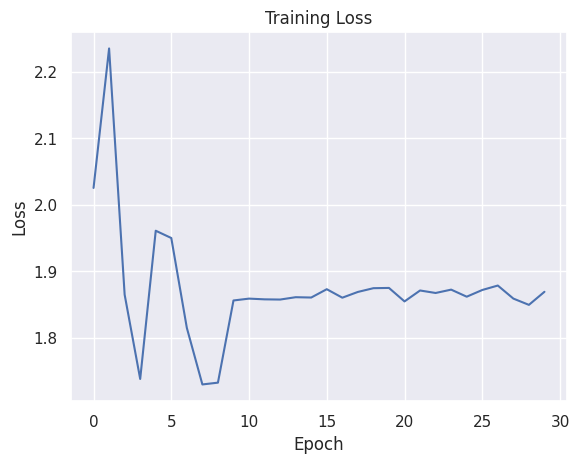

In [52]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [53]:
train_accs = [d.item() for d in train_accs]
test_accs = [d.item() for d in test_accs]

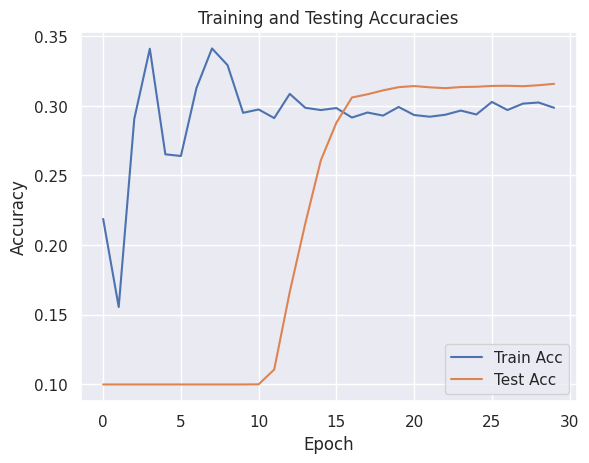

In [54]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [55]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = evaluate_model(global_model, test_loader, device,)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 0.0, Accuracy: 31.579998016357422%
44.77 MB
CPU Inference Latency: 7.49 ms / sample
CUDA Inference Latency: 7.20 ms / sample


In [56]:
save_model(global_model, "saved_models", f'resnet_fedlern_{quantize_bits}bits_{time_stamp()}.pth')